In [1]:
import pandas as pd
import geopandas as gpd
import maup
import itertools
import seaborn as sns

In [2]:
wi_wards = gpd.read_file("wards/")

primaries = pd.read_csv("2018_primaries_parsed.csv")

primaries["ward_jurisdiction_norm"] = primaries["ward_jurisdiction"].replace('SAUK COUNTY, TOWN OF LA VALLE', 'SAUK COUNTY, TOWN OF LAVALLE')
primaries["ward_jurisdiction_norm"] = primaries["ward_jurisdiction_norm"].replace('MARATHON COUNTY, VILLAGE OF BROKAW', "MARATHON COUNTY, VILLAGE OF MAINE")
primaries["ward_jurisdiction_norm"] = primaries["ward_jurisdiction_norm"].replace('SAUK COUNTY, TOWN OF LA VALLE', 'SAUK COUNTY, TOWN OF LAVALLE')
primaries["ward_jurisdiction_norm"] = primaries["ward_jurisdiction_norm"].replace('SAUK COUNTY, TOWN OF LA VALLE', 'SAUK COUNTY, TOWN OF LAVALLE')
wi_wards["WARD_MAPPING_LOC"] = wi_wards.index
# primaries["PRIMARIES_MAPPING_LOC"] = primaries.index

wi_wards["ward_jurisdiction"] = wi_wards["new_wards_"].apply(lambda x: x.replace(" ,", ","))

In [3]:
wi_wards["WARD_NUM"] = wi_wards["LABEL"].apply(lambda x: x.split()[-1].lstrip("0"))

## Creating mapping

In [4]:
primaries["PRIMARIES_MAPPING_LOC"] = primaries.index
wi_wards["join_key"] = (wi_wards["ward_jurisdiction"] + wi_wards["WARD_NUM"]).astype(str)
assert wi_wards["join_key"].is_unique

In [5]:
mapping_wards_primaries = {}
for c, row in primaries.iterrows():
    for ward in eval(row["ward_list"]):
        mapping_wards_primaries[row["ward_jurisdiction_norm"] + ward] = row["PRIMARIES_MAPPING_LOC"]
    

In [6]:
wi_wards["PRIMARIES_MAPPING_LOC"] = wi_wards["join_key"].apply(lambda x: mapping_wards_primaries.get(x))
print(wi_wards["PRIMARIES_MAPPING_LOC"].isna().sum())  # number of unassigned wards
print(wi_wards[wi_wards["PRIMARIES_MAPPING_LOC"].isna()]["PERSONS18"].sum())  # tot pop of unassigned wards

125
7781


In [7]:
primaries["PERSONS18"] = wi_wards.groupby("PRIMARIES_MAPPING_LOC")["PERSONS18"].sum()

In [8]:
wi_wards["PERSONS18"].sum() - primaries["PERSONS18"].sum()  # expected and reasonable

7781.0

In [9]:
set(mapping_wards_primaries.keys()) - set(wi_wards["join_key"])

{'DODGE COUNTY, TOWN OF WILLIAMSTOWN1',
 'DODGE COUNTY, TOWN OF WILLIAMSTOWN2',
 'DODGE COUNTY, TOWN OF WILLIAMSTOWN3',
 'MONROE COUNTY, CITY OF TOMAH5',
 'MONROE COUNTY, TOWN OF LA GRANGE1A-3A',
 'MONROE COUNTY, TOWN OF LA GRANGE1B-3B',
 'OZAUKEE COUNTY, CITY OF MEQUON6-7A',
 'TREMPEALEAU COUNTY, TOWN OF LINCOLN2',
 'WALWORTH COUNTY, CITY OF DELAVAN16',
 'WALWORTH COUNTY, CITY OF WHITEWATER13',
 'WINNEBAGO COUNTY, CITY OF MENASHA1A-2',
 'WINNEBAGO COUNTY, TOWN OF VINLAND1A-2',
 'WINNEBAGO COUNTY, TOWN OF WOLF RIVER1-2A',
 'WOOD COUNTY, CITY OF MARSHFIELD25',
 'WOOD COUNTY, CITY OF MARSHFIELD26',
 'WOOD COUNTY, CITY OF MARSHFIELD27',
 'WOOD COUNTY, CITY OF WISCONSIN RAPIDS26',
 'WOOD COUNTY, CITY OF WISCONSIN RAPIDS27',
 'WOOD COUNTY, CITY OF WISCONSIN RAPIDS28',
 'WOOD COUNTY, CITY OF WISCONSIN RAPIDS29'}

In [10]:
set(wi_wards["join_key"]) - set(mapping_wards_primaries.keys())

{'CALUMET COUNTY, CITY OF BRILLION5',
 'CALUMET COUNTY, CITY OF KIEL10',
 'CHIPPEWA COUNTY, CITY OF EAU CLAIRE78',
 'COLUMBIA COUNTY, CITY OF WISCONSIN DELLS12',
 'DANE COUNTY, CITY OF MADISON145',
 'DANE COUNTY, CITY OF MADISON146',
 'DANE COUNTY, CITY OF MADISON147',
 'DANE COUNTY, CITY OF MADISON148',
 'DANE COUNTY, CITY OF MADISON149',
 'DANE COUNTY, CITY OF MADISON150',
 'DANE COUNTY, CITY OF MADISON151',
 'DANE COUNTY, CITY OF MADISON152',
 'DANE COUNTY, CITY OF MADISON154',
 'DANE COUNTY, CITY OF MIDDLETON21',
 'DANE COUNTY, CITY OF MIDDLETON22',
 'DANE COUNTY, CITY OF STOUGHTON15',
 'DANE COUNTY, CITY OF STOUGHTON16',
 'DANE COUNTY, CITY OF SUN PRAIRIE26',
 'DANE COUNTY, CITY OF SUN PRAIRIE27',
 'DANE COUNTY, CITY OF SUN PRAIRIE28',
 'DANE COUNTY, TOWN OF CROSS PLAINS4',
 'DANE COUNTY, VILLAGE OF COTTAGE GROVE13',
 'DANE COUNTY, VILLAGE OF DEFOREST22',
 'DANE COUNTY, VILLAGE OF MCFARLAND13',
 'DANE COUNTY, VILLAGE OF MCFARLAND14',
 'DODGE COUNTY, CITY OF BEAVER DAM15',
 'DODGE 

### Epsilon trick

In [11]:
e = 1e-10

In [12]:
wi_wards["PERSONS18ADJ"] = wi_wards["PERSONS18"].replace(0, e)
wi_wards["PERSONS18ADJ"].sum()

4347494.000000039

In [13]:
primaries["PERSONS18ADJ"] = wi_wards.groupby("PRIMARIES_MAPPING_LOC")["PERSONS18ADJ"].sum()

In [14]:
wi_wards["PERSONS18ADJ"].sum() - primaries["PERSONS18ADJ"].sum()  # expected and reasonable

7781.000000007451

### Prorating

In [15]:
wi_wards_stripped = wi_wards[~wi_wards["PRIMARIES_MAPPING_LOC"].isna()]

In [16]:
election_columns = [x for x in primaries.columns if (" " in x and x != "WARD GROUP") or "TOTAL" in x]
election_columns

['PLGTOTAL',
 'KURT J. KOBER',
 'MANDELA  BARNES',
 'CORBAN GEHLER (WRITE-IN)',
 'WILLIAM HENRY DAVIS III (WRITE-IN)',
 'PGOVTOTAL',
 'ANDY GRONIK',
 'MATT FLYNN',
 'TONY EVERS',
 'JOSH PADE',
 'MIKE MCCABE',
 'MAHLON MITCHELL',
 'KELDA HELEN ROYS',
 'PAUL R. SOGLIN',
 'KATHLEEN VINEHOUT',
 'DANA WACHS',
 'PAUL BOUCHER (WRITE-IN)',
 'PSOSTOTAL',
 'DOUG  LA FOLLETTE',
 'ARVINA MARTIN',
 'PTRESTOTAL',
 'DAWN MARIE  SASS',
 'CYNTHIA  KAUMP',
 'SARAH  GODLEWSKI']

In [17]:
weights = (wi_wards_stripped["PERSONS18ADJ"] / wi_wards_stripped["PRIMARIES_MAPPING_LOC"].map(primaries["PERSONS18ADJ"]))

In [18]:
len(primaries)

3658

In [19]:
assigned_primaries = set(primaries["PRIMARIES_MAPPING_LOC"].astype(float)).intersection(set(wi_wards_stripped["PRIMARIES_MAPPING_LOC"]))
unassigned_primaries = set(primaries["PRIMARIES_MAPPING_LOC"].astype(float)) - set(wi_wards_stripped["PRIMARIES_MAPPING_LOC"])

In [20]:
primaries.iloc[[int(x) for x in unassigned_primaries]]["PLGTOTAL"].sum() / primaries["PLGTOTAL"].sum()

0.0010131964687611597

In [21]:
weights.isna().sum()

0

In [22]:
wi_wards_stripped["PRIMARIES_MAPPING_LOC"].astype(int).isna().sum()

0

In [23]:
prorated = maup.prorate(wi_wards_stripped["PRIMARIES_MAPPING_LOC"], primaries.iloc[list(assigned_primaries)][election_columns], weights)

In [24]:
primaries[election_columns].sum() - prorated.round(5)[election_columns].sum()

PLGTOTAL                              488.00007
KURT J. KOBER                         195.99986
MANDELA  BARNES                       291.00023
CORBAN GEHLER (WRITE-IN)                0.00000
WILLIAM HENRY DAVIS III (WRITE-IN)      0.00000
PGOVTOTAL                             519.99996
ANDY GRONIK                            10.99994
MATT FLYNN                             32.99999
TONY EVERS                            270.99998
JOSH PADE                               2.00020
MIKE MCCABE                            26.99989
MAHLON MITCHELL                        58.00018
KELDA HELEN ROYS                       57.99992
PAUL R. SOGLIN                         13.00008
KATHLEEN VINEHOUT                      44.99980
DANA WACHS                              1.99991
PAUL BOUCHER (WRITE-IN)                 0.00000
PSOSTOTAL                             499.99989
DOUG  LA FOLLETTE                     364.00006
ARVINA MARTIN                         135.99986
PTRESTOTAL                            47

In [25]:
wi_wards_stripped[election_columns] = prorated

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [26]:
cols = election_columns + ["ID"]

In [27]:
for col in election_columns:
    if col in wi_wards:
        del wi_wards[col]
wi_wards = wi_wards.merge(wi_wards_stripped[cols], on = "ID", how = "left")

In [28]:
wi_wards.to_csv("WI_18_NEW_PRIMARIES.csv")

In [30]:
wi_wards.to_file("WI_18_NEW_PRIMARIES.shp")

/tmp/ipykernel_1273375/1698897101.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  wi_wards.to_file("WI_18_NEW_PRIMARIES.shp")


In [311]:
primaries[election_columns].sum() - wi_wards[election_columns].sum()

KURT J. KOBER                         196.0
MANDELA  BARNES                       291.0
CORBAN GEHLER (WRITE-IN)                0.0
WILLIAM HENRY DAVIS III (WRITE-IN)      0.0
ANDY GRONIK                            11.0
MATT FLYNN                             33.0
TONY EVERS                            271.0
JOSH PADE                               2.0
MIKE MCCABE                            27.0
MAHLON MITCHELL                        58.0
KELDA HELEN ROYS                       58.0
PAUL R. SOGLIN                         13.0
KATHLEEN VINEHOUT                      45.0
DANA WACHS                              2.0
PAUL BOUCHER (WRITE-IN)                 0.0
DOUG  LA FOLLETTE                     364.0
ARVINA MARTIN                         136.0
DAWN MARIE  SASS                      152.0
CYNTHIA  KAUMP                        136.0
SARAH  GODLEWSKI                      185.0
dtype: float64

## Matching Checks

In [108]:
wi_wards["ID"]

0       55001002750001
1       55001002750002
2       55001002750003
3       55001002750004
4       55001003000001
             ...      
7073    55101660000001
7074    55139557500027
7075    55139557500028
7076    55139598750009
7077    55139605000043
Name: ID, Length: 7078, dtype: object

In [109]:
wi_wards[wi_wards["LABEL"].duplicated()]["PERSONS18"].sum()

152686

<AxesSubplot:xlabel='PERSONS18', ylabel='Count'>

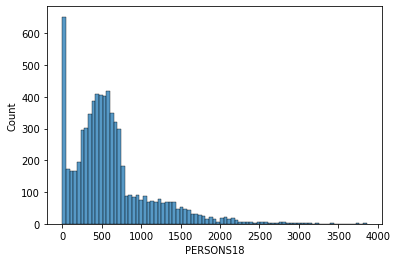

In [132]:
sns.histplot(wi_wards["PERSONS18"])

<AxesSubplot:xlabel='PERSONS18', ylabel='Count'>

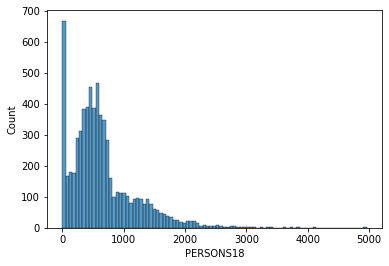

In [114]:
sns.histplot(wi_wards.groupby("LABEL").sum()["PERSONS18"])

<AxesSubplot:xlabel='PERSONS18', ylabel='Count'>

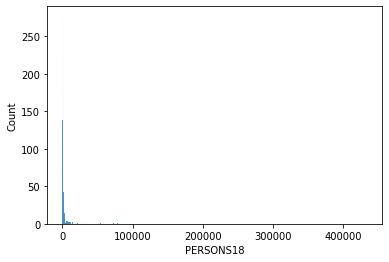

In [120]:
sns.histplot(wi_wards.groupby("ward_jurisdiction").sum()["PERSONS18"])